<a href="https://colab.research.google.com/github/YOKESH-P-S/Noise-Reduction-Project/blob/main/Noise_Reduction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pydub noisereduce numpy scipy
!pip install librosa
!pip install --upgrade librosa
!pip install noisereduce

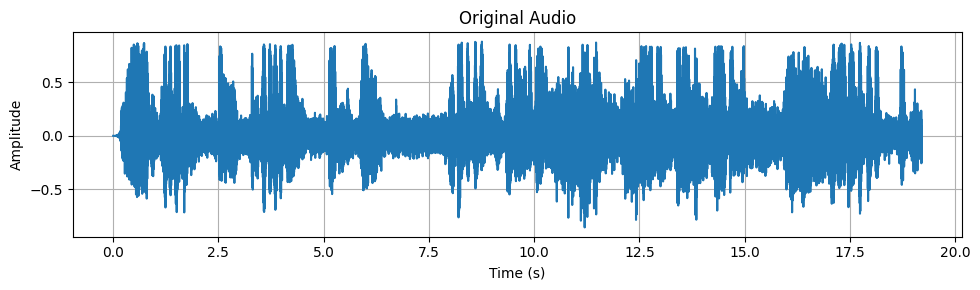

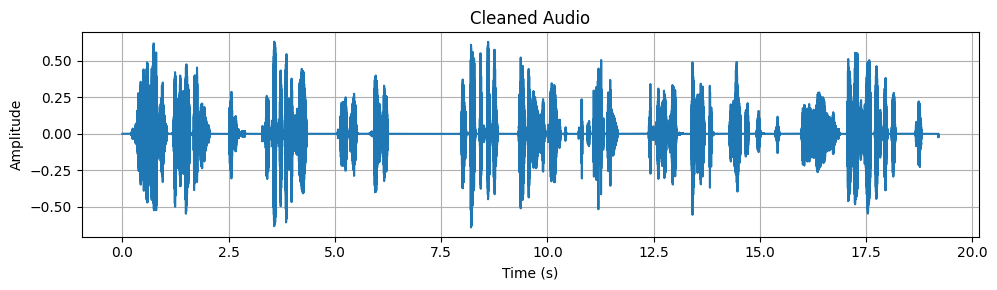

Cleaned audio saved to cleaned audio.mp3
Noise reduction by: 72.09 %


In [14]:
from pydub import AudioSegment
import numpy as np
import librosa
import noisereduce as nr
import matplotlib.pyplot as plt

def plot_waveform(audio_array, sample_rate, title):
    time = np.linspace(0, len(audio_array) / sample_rate, num=len(audio_array))
    plt.figure(figsize=(10, 3))
    plt.plot(time, audio_array)
    plt.title(title)
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def calculate_noise_reduction(original_magnitude, cleaned_magnitude):
    original_energy = np.sum(original_magnitude ** 2)
    cleaned_energy = np.sum(cleaned_magnitude ** 2)

    reduction_ratio = (1 - cleaned_energy / original_energy) * 100
    return reduction_ratio

def reduce_noise_spectral_gating(audio_path, output_path, noise_sample_duration=7.5):
    audio = AudioSegment.from_file(audio_path)
    sample_rate = audio.frame_rate
    audio_array = np.array(audio.get_array_of_samples(), dtype=np.float32) / 32768.0  # Normalize to [-1, 1]

    if audio.channels == 2:
        audio_array = librosa.to_mono(audio_array.reshape(-1, 2).T)

    plot_waveform(audio_array, sample_rate, 'Original Audio')

    stft = librosa.stft(audio_array)
    magnitude, phase = librosa.magphase(stft)

    noise_magnitude = np.mean(magnitude[:, :int(noise_sample_duration * sample_rate)], axis=1, keepdims=True)

    threshold = 5
    mask = magnitude > (noise_magnitude * threshold)
    reduced_magnitude = magnitude * mask

    reduced_stft = reduced_magnitude * phase
    reduced_audio_array = librosa.istft(reduced_stft)

    reduced_audio = AudioSegment(
        (reduced_audio_array * 32768).astype(np.int16).tobytes(),
        frame_rate=sample_rate,
        sample_width=2,
        channels=1
    )

    reduced_audio.export(output_path, format="wav")

    plot_waveform(reduced_audio_array, sample_rate, 'Cleaned Audio')

    print(f"Cleaned audio saved to {output_path}")

    reduction_dB = calculate_noise_reduction(magnitude, reduced_magnitude)
    print(f"Noise reduction by: {reduction_dB:.2f} %")

if __name__ == "__main__":
    audio_path = "input sample.mp3"
    output_path = "cleaned audio.mp3"  # Change the output format to WAV for better compatibility

    reduce_noise_spectral_gating(audio_path, output_path)
